# Nixie Voltage Regulator
## Basic Design Parameters
In this section we will define the basic parameters of the Voltage Regulator. We will specify known quantities at this stage such as input voltage, required output current, total power, basic efficiency calculations etc.

In [1]:
from pint import UnitRegistry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
ureg = UnitRegistry()

#Input Voltage Range
VinMin = 4.0 * ureg.V
VinNom = 5.0 * ureg.V
VinMax = 6.0 * ureg.V

Vout = 180 * ureg.V

#Load Current
NixieCurrent = 2.5 * ureg.mA
NumNixie = 6
# Total current draw of Nixies + some fudge factor.
MaxDesignCurrent = (NixieCurrent * NumNixie + (2.5 * ureg.mA)).to("A")

OutputPower = (MaxDesignCurrent * Vout).to("W")
InputCurrent = OutputPower / VinNom

Eff = 0.7

print("Basic Design Parameters".center(80,'='))
print("Assuming efficiency of ",Eff,"%\n")
print("Input Params\tOutput Params")
print(VinNom,Vout,sep='\t')
print(OutputPower/Eff,OutputPower,sep='\t')
print(((OutputPower/Eff)/VinNom).to("A"),MaxDesignCurrent)

============================Basic Design Parameters=============================
Assuming efficiency of  0.7 %

Input Params	Output Params
5.0 volt	180 volt
4.500000000000001 watt	3.1500000000000004 watt
0.9000000000000001 ampere 0.0175 ampere


We can see that the power requirements for the converter are quite low at less than 5 watt. This means that the converter should be capable of being powered from a suitably powerful USB source such as a mobile phone charger or power bank.

### Boost Converter in CCM Mode
Firstly, we'll calculate what the solution will look like in CCM mode as it's simpler to work out and our load is relativley constant and well understood.

### Duty Cycle

Duty Cycle in CCM is defined as the following.

$D=1-\dfrac{V_{in}}{V_{out}+V_d}$

where $V_d$ is the forward voltage of the boost diode.

In [31]:
#Diode Voltage Drop
VDropD = 1 * ureg.V # Assuming 1V for now.

Duty = 1 - ((VinMin)/(Vout+VDropD))

print('{:.4f}'.format(Duty.magnitude))

0.9779


A 97% Duty Cycle is really high, but do-able for some converters. We'll be spending most of our time with the MOSFET switched on so it'll need to have a good RDSon.

### Inductor Selection

For a Boost Converter to operate in CCM there must be a minumum load at the output in order to maintain a constant current through the inductor to prevent the converter from switching into DCM. Because the converter is only going to be powering 6 Nixie tubes and will be shut down when I don't want the tubes to be lit then we can rely on a fairly constant load.

However, if PWM brightness control is implemented (which it will) then CCM will not be suitable and a DCM mode Boost of Flyback will be needed instead.

For now lets push on and pretend this isnt a factor.

The minumum inductance required for a Boost Converter operating in CCM mode for a given inductor current and switching frequency is given as:

$L>\dfrac{D(1-D)V_{in}}{2I_{out}f_s}$

[100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000, 1000000, 1010000, 1020000, 1030000, 1040000, 1050000, 1060000, 1070000, 1080000, 1090000]


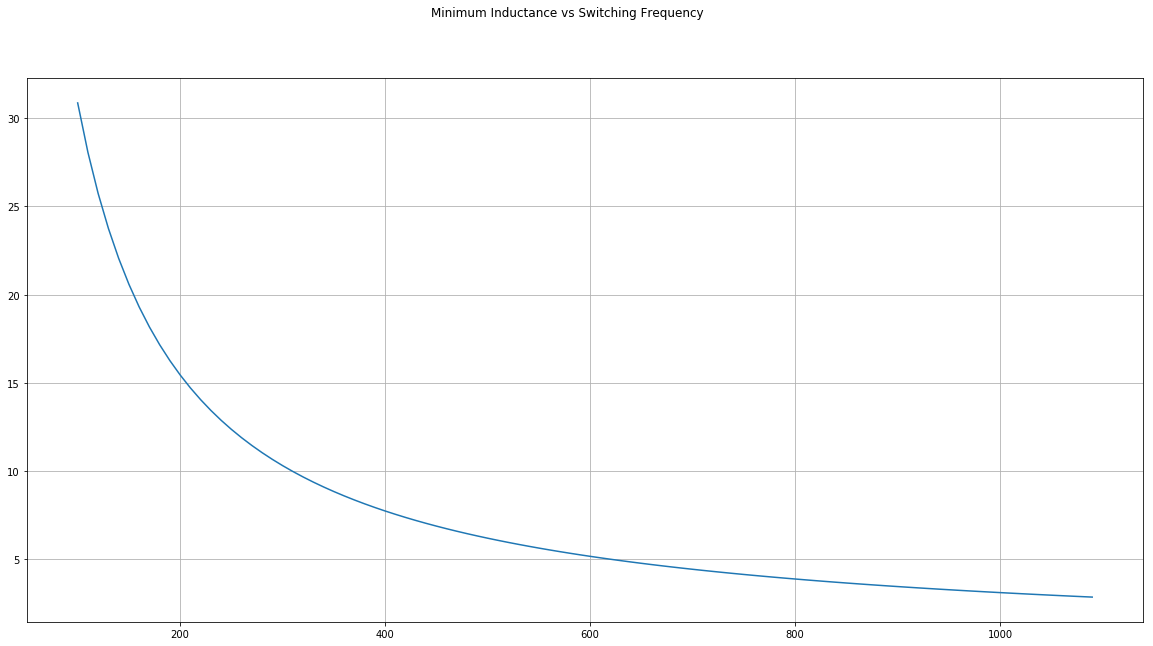

In [32]:
#Build a list 
startFreq = (100 * ureg.kHz).to("Hz")
endFreq = (1.1 * ureg.MHz).to("Hz")
stepFreq = (10 * ureg.kHz).to("Hz")

Fs = list(range(int(startFreq.magnitude),
                int(endFreq.magnitude),
                int(stepFreq.magnitude)))
print(Fs)

L = ((Duty*(1-Duty)*VinNom) / (2*MaxDesignCurrent.to("A")*Fs)).magnitude * ureg.H
#print(L.to("uH"))

fig = plt.figure(figsize=(20,10))
fig.suptitle("Minimum Inductance vs Switching Frequency")
ax = fig.add_subplot(1, 1,1)
ax.plot((Fs * ureg.Hz).to("kHz"),L.to("uH"))
ax.grid(which="both")
plt.show()

It is observed that as the minimum inductance required to keep the converter operating in CCM decreases rapidly as the switching frequency of the converter increases. 

For the purposes of this design, 400kHz looks like a good point to select as we can operate in CCM using relativley common 10µH inductors. Alternativley, we can force the system to operate in DCM mode by setting our switching frequency to ~200kHz, this also has added benefit of reducing switching losses due to higher switching rates.


## Flyback in DCM

Based on some analysis and research into other designs for achieving similar voltages and currents, flyback converters seem to be able to eke out slightly better efficiencies due to a reduction in losses in the inductor, switch and diode.

[See build at 0x7D.com for Kevin's analysis.](https://0x7d.com/2017/nixie-tube-clock/#Custom_Power_Supply)

### Duty Cycle In CCM

$D_{CCM(flyback)}=\dfrac{V_{out}+V_D}{(N_{s:p}\times V_{in})+V_{out}+V_D}$

[0.97837838 0.95767196 0.93782383 0.91878173 0.90049751 0.88292683 0.86602871 0.84976526 0.83410138 0.81900452 0.80444444 0.79039301 0.77682403 0.76371308 0.75103734 0.73877551 0.72690763 0.71541502 0.70428016 0.69348659] dimensionless


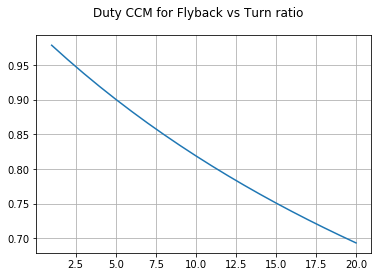

In [33]:
#Diode Voltage Drop
VDropD = 1 * ureg.V # Assuming 1V for now.

Nturns = list(range(1,21))

Duty = (Vout + VDropD) \
    / ((Nturns * VinMin) + Vout + VDropD)

print(Duty)

fig = plt.figure()
fig.suptitle("Duty CCM for Flyback vs Turn ratio")
ax = fig.add_subplot(1, 1,1)
ax.plot(Nturns,Duty)
ax.grid(which="both")
plt.show()

Here we can see that the required duty cycle for a particular output voltage decreases almost linearly versus the number of turns in our transformer. Ideally we should select a transformer with a larger turns ratio to reduce our duty cycle while remaining under the current limit due to it's larger inductance.

In [34]:
#Build a list 
startFreq = (100 * ureg.kHz).to("Hz")
endFreq = (400 * ureg.kHz).to("Hz")
stepFreq = (10 * ureg.kHz).to("Hz")

Fs = list(range(int(startFreq.magnitude),
                int(endFreq.magnitude),
                int(stepFreq.magnitude)))
print(Fs)

list(zip(Duty,Fs))
MinL = list()
for D in Duty:
    for F in Fs:
        L = (((VinMin**2)*(D**2))/(2*MaxDesignCurrent*(Vout+VDropD)*F)).magnitude * ureg.H
        MinL.append(list([np.round(D.magnitude,3),(F * ureg.Hz).to("kHz"),np.round(L.to("uH"),1)]))

df = pd.DataFrame(list(zip(Duty.magnitude,np.round(L.to("uH"),1))),columns = ["Duty", "Inductance"])
df = pd.DataFrame(MinL,columns = ["Duty", "Frequency","Inductance"])
display(df)

[100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000]


,Duty,Frequency,Inductance
0,0.978,100.0 kilohertz,24.2 microhenry
1,0.978,110.0 kilohertz,22.0 microhenry
2,0.978,120.0 kilohertz,20.1 microhenry
3,0.978,130.0 kilohertz,18.6 microhenry
4,0.978,140.0 kilohertz,17.3 microhenry
5,0.978,150.0 kilohertz,16.1 microhenry
6,0.978,160.0 kilohertz,15.1 microhenry
7,0.978,170.0 kilohertz,14.2 microhenry
8,0.978,180.0 kilohertz,13.4 microhenry
9,0.978,190.0 kilohertz,12.7 microhenry
